# Scalar Inversion Problem for UQ
This is a simple scalar inversion problem used to showcase the intrinsic UQ in ensemble methods. 
Three different methods are compared: EnKF, EnKF-MDA, and EnRML. Both EnKF-MDA and EnRML are superior to the base EnKF when it comes to UQ ability. 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import dafi

mpl.rcParams.update({'text.usetex': True, 'text.latex.preamble': '\\usepackage{gensymb}',})

## Problem Description
The state consists of two scalar values
\begin{gather*}
    x = \begin{bmatrix} x_1\\ x_2\end{bmatrix} .
\end{gather*}
The observations are of two quantities derived from the state, given by the observation operator as 
\begin{gather*}
    y = \mathsf{H}x = \begin{bmatrix} x_1\\ x_1 + x_2^3 \end{bmatrix} .
\end{gather*}
We beleive the prior value to be close to $x=[0.5, 0.5]^\top$ and use a multivariate normal distribution to represent our confidence in this estimate. The two states are considered independent each with standard deviation of $0.1$. The prior distribution is thus 
\begin{gather*}
    x \sim \mathcal{N}\left( \begin{bmatrix} 0.5\\ 0.5\end{bmatrix}, \begin{bmatrix} 0.1^2 & 0\\ 0& 0.1^2\end{bmatrix} \right) .
\end{gather*}

A single observation with values $y=[0.8, 2.0]^\top$ is available. The standard deviation associated with each measurement is $0.05$ and the two measurements are independent. 
The observation is thus 
\begin{gather*}
    y \sim \mathcal{N}\left( \begin{bmatrix} 0.8\\ 2.0\end{bmatrix}, \begin{bmatrix} 0.05^2 & 0\\ 0& 0.05^2\end{bmatrix} \right) .
\end{gather*}
The goal is then to infer the correct state $x$ from this observation and the prior belief. 


## Create Inputs
First we create a dictionary with all the required inputs to DAFI. This will make calling the DAFI.run function easier. 
The PhysicsModel class for this problem is implemented in the file *model.py*. We will use $1000$ samples and a stopping criteria based on the discrepancy principle (excpet for the EnKF-MDA which needs no stopping criteria) with a factor of $1.2$ and a maximum of $100$ iterations. The EnRML requires the observations to be perturbed only once. This is achieved by specifying 'perturb_obs_option' as 'time' (this is done by the DAFI but specifying it here avoids a warning). The EnKF-MDA required the additional input of number of steps, which we set to $10$. The EnRML requires the additional input of step length, which is between $0$--$1$, and we set as $0.5$. These inverse method--specific inputs are specified in the *inputs_inverse* dictionary.

In [2]:
# CHOOSE ONE
inverse_method = 'EnKF-MDA' # in ['EnKF', 'EnKF-MDA', 'EnRML']

In [3]:
if inverse_method == 'EnKF':
    inputs_dafi = {
        'model_file': 'model.py',
        'inverse_method': 'EnKF',
        'nsamples': 1000,
        'max_iterations': 100,
        'convergence_option': 'discrepancy',
        'convergence_factor': 1.2,
    }
    
    inputs_inverse = {}
    
elif inverse_method == 'EnKF-MDA':
    inputs_dafi = {
        'model_file': 'model.py',
        'inverse_method': 'EnKF_MDA',
        'nsamples': 1000,
    }
    
    inputs_inverse = {'nsteps': 10,}
    
elif inverse_method == 'EnRML':
    inputs_dafi = {
        'model_file': 'model.py',
        'inverse_method': 'EnRML',
        'nsamples': 1000,
        'max_iterations': 100,
        'convergence_option': 'discrepancy',
        'convergence_factor': 1.2, 
        'perturb_obs_option': 'time',
    }
    
    inputs_inverse = {'step_length': 0.5,}

The inputs to the physics model (specified in *model.py*) are the mean and standard deviations of the two prior states and the two observations. These are specified in the *inputs_model* dictionary.

In [4]:
inputs_model = {
    'x_init_mean': [0.5, 0.5],
    'x_init_std': [0.1, 0.1],
    'obs': [0.8, 2.0],
    'obs_std': [0.05, 0.05],
}

## Run DAFI
With the three sets of inputs specified, we are now ready to run DAFI. 

In [5]:
posterior = dafi.run(**inputs_dafi, inputs_inverse=inputs_inverse, inputs_model=inputs_model)

Solving the inverse problem
Physics Model:  Scalar Inversion Case for UQ
Inverse Method: Ensemble Kalman Filter-Multi Data Assimilation (EnKF-MDA)
Done.


## Results
### Posterior Estimate and Uncertainty
First we plot the resulting posterior ensemble. This posterior can be used to obtain an estimate (mean, MAP) and to quantify the uncertainty in this estimate (covariance). Both the samples and a kernel density estimate are plotted below.

/Users/cmichel/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/cmichel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/cmichel/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>

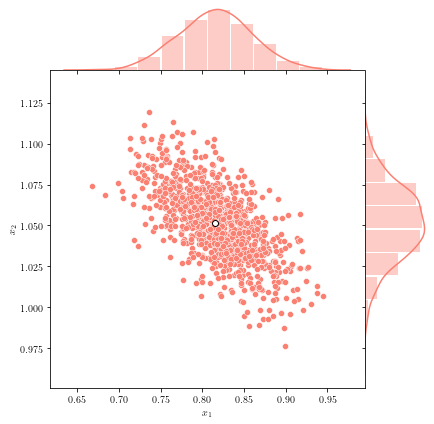

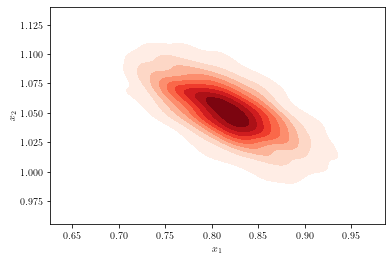

In [6]:
posteriordf = pd.DataFrame(posterior.T, columns=["$x_1$", "$x_2$"])

g = sns.JointGrid(x="$x_1$", y="$x_2$", data=posteriordf, space=0)
g = g.plot_joint(sns.scatterplot, color='salmon')
g = g.plot_marginals(sns.distplot, kde=False, color="salmon", bins=10, norm_hist=True, hist_kws={'rwidth': 0.95})
g = g.plot_marginals(sns.kdeplot, color="salmon", shade=False)
g.ax_joint.plot(posteriordf['$x_1$'].mean(), posteriordf['$x_2$'].mean(), 'o', markerfacecolor='w' ,markeredgecolor='k')


fig, ax = plt.subplots()
sns.kdeplot(posteriordf['$x_1$'], posteriordf['$x_2$'], ax=ax, cmap='Reds', shade=True, shade_lowest=False)

### Compare Prior and Posterior
We now compare the prior and posterior distributions in both state space and observation space. First some pre-processing. 

In [7]:
# Create the prior Gaussian distribution for plotting
prior_mean = inputs_model['x_init_mean']
prior_cov = np.diag(inputs_model['x_init_std'])
prior = np.random.multivariate_normal(prior_mean, prior_cov, 10000)
priordf = pd.DataFrame(prior, columns=["$x_1$", "$x_2$"])

# Create the observation Gaussian distribution for plotting
obs_mean = inputs_model['obs']
obs_cov = np.diag(inputs_model['obs_std'])
obs = np.random.multivariate_normal(obs_mean, obs_cov, 10000)
obsdf = pd.DataFrame(obs, columns=["$y_1$", "$y_2$"])

We also need to map the posterior states to observation space. This could be done during the DAFI run if both *analysis_to_obs=True* and *save_level* was set to anything other *None*, in which case the results would be saved to text files. Here however we will use the physics model directly, since for this scalar case it runs quickly. 

In [8]:
import model 

# initialize the model
pmodel = model.Model(inputs_dafi, inputs_model)

# map states to observation space
prior_obs = pmodel.state_to_observation(prior.T)
posterior_obs = pmodel.state_to_observation(posterior)

priordf['$y_1$']=prior_obs[0,:]
priordf['$y_2$']=prior_obs[1,:]
posteriordf['$y_1$']=posterior_obs[0,:]
posteriordf['$y_2$']=posterior_obs[1,:]

Now we plot. In the plots below the prior distribution is in blue, the posterior in red, and the observations in black. First we plot in the state space where it can be seen that the posterior mean has shifted compared to the prior and the posterior covariance is much smaller. Then we plot in the observation space where we see the posterior has gotten much closer to the observation values. 

Run again with a different choice of inverse method to compare. EnKF tends to collapse, predicting much smaller and incorrect posterior covariance. 

[(-0.5, 3.0), (-0.5, 3.0)]

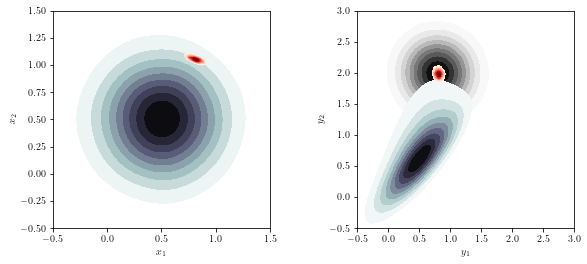

In [9]:
# options
shade = True
bw_prior = np.mean(prior_mean)
bw_obs = np.mean(obs_mean)
lim_state = (-0.5, 1.5)
lim_obs = (-0.5, 3.0)

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))


sns.kdeplot(x=priordf['$x_1$'], y=priordf['$x_2$'], ax=axs[0], cmap='bone_r', shade=shade, thresh=0.1, bw_method=bw_prior)
sns.kdeplot(x=posteriordf['$x_1$'], y=posteriordf['$x_2$'], ax=axs[0], cmap='Reds', shade=shade, thresh=0.1)
axs[0].set_aspect('equal', 'box')
axs[0].set(xlim=lim_state, ylim=lim_state)

sns.kdeplot(x=obsdf['$y_1$'], y=obsdf['$y_2$'], ax=axs[1], cmap='Greys', shade=shade, thresh=0.1, bw_method=bw_obs)
sns.kdeplot(x=priordf['$y_1$'], y=priordf['$y_2$'], ax=axs[1], cmap='bone_r', shade=shade, thresh=0.1, bw_method=bw_prior)
sns.kdeplot(x=posteriordf['$y_1$'], y=posteriordf['$y_2$'], ax=axs[1], cmap='Reds', shade=shade, thresh=0.1)
axs[1].set_aspect('equal', 'box')
axs[1].set(xlim=lim_obs, ylim=lim_obs)


Now we plot only the mean values. 

[(-0.5, 3.0), (-0.5, 3.0), Text(0.5, 0, '$y_1$'), Text(0, 0.5, '$y_2$')]

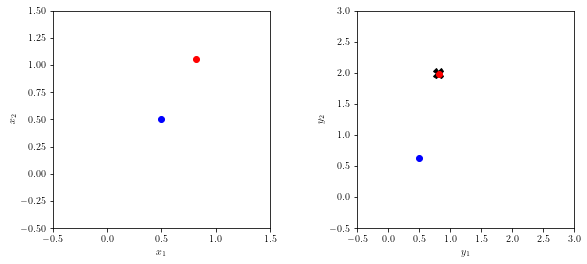

In [10]:
# map prior mean to observation space
prior_mean_obs = pmodel.state_to_observation(np.expand_dims(prior_mean, axis=1))

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(prior_mean[0], prior_mean[1], 'bo')
axs[0].plot(posteriordf['$x_1$'].mean(), posteriordf['$x_2$'].mean(), 'ro')
axs[0].set_aspect('equal', 'box')
axs[0].set(xlim=lim_state, ylim=lim_state, xlabel="$x_1$", ylabel="$x_2$")

axs[1].plot(obs_mean[0], obs_mean[1], 'kX', markersize=10)
axs[1].plot(prior_mean_obs[0], prior_mean_obs[1], 'bo')
axs[1].plot(posteriordf['$y_1$'].mean(), posteriordf['$y_2$'].mean(), 'ro')
axs[1].set_aspect('equal', 'box')
axs[1].set(xlim=lim_obs, ylim=lim_obs, xlabel="$y_1$", ylabel="$y_2$")
